In [37]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
# import corner
# import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
# from ltsfit.lts_linefit import lts_linefit

In [38]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [39]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21


df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'F21', 'eF21'],
      dtype='object', length=118)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,34.024557,-34.024557,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557,0.00,4.729334,0.805837
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,33.717026,-18.127026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,0.47,1.926637,0.134862
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,34.620362,-34.620362,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362,0.00,3.400948,0.579492
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,34.281429,-19.921429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,0.78,1.194538,0.203539
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,33.894131,-18.364131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,0.31,4.541507,0.317899


In [40]:
df.columns

Index(['Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'F21', 'eF21'],
      dtype='object', length=118)

In [41]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [42]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flux
PGC,
2,4.73
4,1.85
6,0.82
12,3.40
16,1.19


In [43]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"v3k":"V3k"})

df.head()

,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,-34.024557,-34.024557,-22.134557,-21.504557,0.00,4.729334,0.805837,NaN,NaN,4.73
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,-18.597026,-18.647026,-17.647026,-17.277026,0.47,1.926637,0.134862,1.96,0.07,1.85
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,-34.620362,-34.620362,-21.030362,-20.390362,0.00,3.400948,0.579492,NaN,NaN,3.40
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,-20.701429,-20.881429,-20.291429,-19.581429,0.78,1.194538,0.203539,NaN,NaN,1.19
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,-18.674131,-18.724131,-17.694131,-17.264131,0.31,4.541507,0.317899,NaN,NaN,4.30


In [44]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)

len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

<ipython-input-44-b6dbfbfb12cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-44-b6dbfbfb12cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


In [45]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536, 21102,50073, 5896, 15345] 
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi']]).dropna()
calib = calib[(calib.Qw>2) & (calib['W1']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)

calib['M1'] = calib.W1-calib.dm19
gamma = np.log10(0.5) + 0.4*5.91
calib['logMs_W1'] = gamma - 0.4*calib['M1']
calib['Ms_W1'] = 10**calib.logMs_W1

# calib = calib[calib.M1<-16.1]

calib = calib.dropna()


print(len(calib))
calib.head()

81


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,Qs,Qw,F21,eF21,elgWi,Dist,Mass_HI,M1,logMs_W1,Ms_W1
PGC,,,,,,,,,,,,,,,,,,,,,
1014,2,NGC0055,26.507,84,2.222,0.034,0.0,0.0,0.0,0.0,...,0.0,5.0,9.69000,342.489616,0.034,2.001705,9.147429e+06,-18.467,9.44977,2.816891e+09
2758,2,NGC0247,27.729,73,2.331,0.013,0.0,0.0,0.0,0.0,...,0.0,5.0,687.38492,137.383765,0.013,3.513986,1.999748e+09,-18.709,9.54657,3.520222e+09
3238,2,NGC0300,26.444,53,2.244,0.063,0.0,0.0,0.0,0.0,...,0.0,5.0,664.34000,283.561594,0.063,1.944464,5.917874e+08,-18.194,9.34057,2.190635e+09
9332,2,NGC0925,29.840,56,2.377,0.021,0.0,0.0,0.0,0.0,...,0.0,5.0,251.63500,0.150000,0.021,9.289664,5.116186e+09,-19.670,9.93097,8.530412e+09
13179,2,NGC1365,31.372,55,2.656,0.026,0.0,0.0,0.0,0.0,...,0.0,5.0,146.45000,24.948671,0.026,18.810485,1.220857e+10,-22.672,11.13177,1.354472e+11


In [46]:
calib.groupby("So").count()

# So = 2 : Both
# So = 0 : CPLR
# So = 1 : TRGB


,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,Mz,...,Qs,Qw,F21,eF21,elgWi,Dist,Mass_HI,M1,logMs_W1,Ms_W1
So,,,,,,,,,,,,,,,,,,,,,
0,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
2,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18


In [47]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [48]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

alfa = 0.4356745719231558 
beta = 1.5772902772798747

df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
df['Ms_i'] = 10**df.logMs_i

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df["logMs_i"][df.Qs==0]=np.nan
df["logMs_W1"][df.Qw==0]=np.nan

df["logMs_av"] = df[["logMs_i", "logMs_W1"]].mean(axis=1)

df[["logMs_av", "logMs_i", "logMs_W1", "i***", "w1***", "Qs", "Qw"]].head()

<ipython-input-48-e4286077c8a0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logMs_i"][df.Qs==0]=np.nan
<ipython-input-48-e4286077c8a0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logMs_W1"][df.Qw==0]=np.nan


,logMs_av,logMs_i,logMs_W1,i***,w1***,Qs,Qw
PGC,,,,,,,
2,10.916793,NaN,10.916793,0.00,11.89,0.0,5.0
4,9.171324,9.220868,9.121780,15.12,16.07,5.0,4.0
12,10.475115,NaN,10.475115,0.00,13.59,0.0,5.0
16,10.188615,10.197688,10.179541,13.58,13.99,5.0,5.0
55,9.161312,9.182002,9.140623,15.22,16.20,5.0,4.0


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f98e45bd850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99044fedc0>)

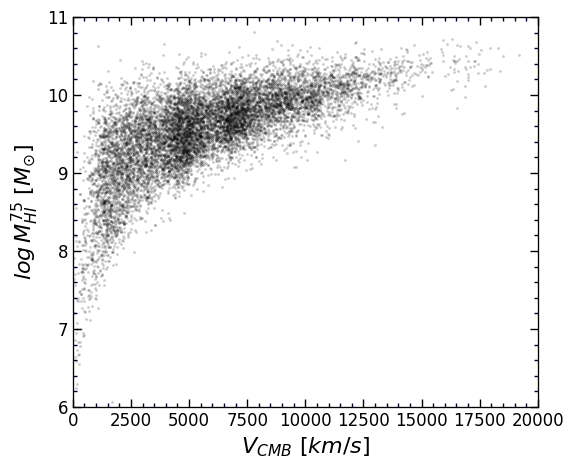

In [49]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

M_HI = np.log10(df['Mass_HI'])
V3k = df.V3k.values

# ax.plot(V3k, M_HI, 'k.', alpha=0.03)
ax.plot(V3k, M_HI, 'ko', alpha=0.20, ms=2, mfc='k', mec='none') 

ax.set_ylabel(r'$log \/M^{75}_{HI} \/\/ [M_{\odot}]$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (6,11), fontsize=12)

iter:  0
iter:  1


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-50-db0481f58e62>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-50-db0481f58e62>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-50-db0481f58e62>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy

Text(1.7650000000000001, 11.600000000000001, '$W1-band$')

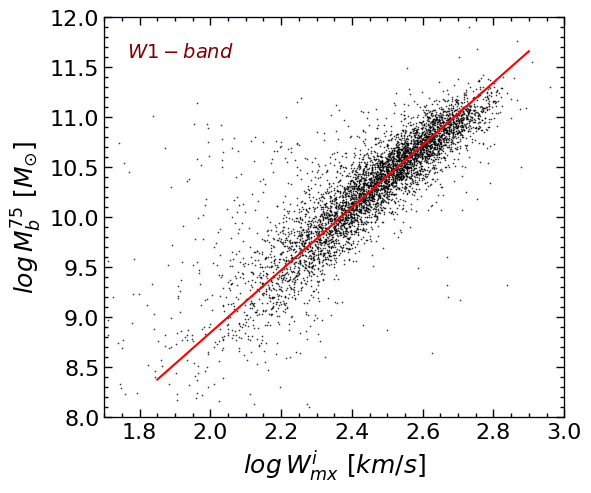

In [50]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>0)]

  


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values



fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

# ax.plot(logW, logMass, 'k.', alpha=0.05) 
ax.plot(logW, logMass, 'ko', alpha=0.8, ms=1.2, mfc='k', mec='none') 



    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

# ax.set_title("W1-band", fontsize=16)


dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.0*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    
w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'r-')

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r"$W1-band$", fontsize=14, color='maroon')

In [51]:
len(df)

10737

2.397277512626916 -5.138224694236482


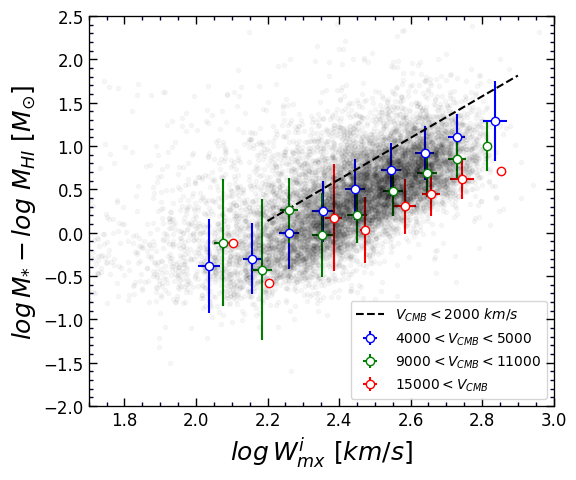

In [60]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[((df.Qw>2)|(df.Qs>2))&(df.elgWi>0)&(df.lgWmxi>0)]
X0 = dff.lgWmxi.values
Y0 = dff.logMs_av.values-np.log10(dff.Mass_HI.values)
V3k = dff.V3k.values
# Y0 = Y0 - (mc*V3k+bc)

ax.plot(X0, Y0, 'k.', alpha=0.03)
# ax.plot(X0, Y0, 'ko', alpha=0.05, ms=3.5, mfc='k', mec='none') 


label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V_{CMB}<11000$'
lab = True
ind, = np.where((V3k>9000)&(V3k<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V_{CMB}$'
lab = True      
ind, = np.where((V3k>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3.0,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}-log \/\/ M_{HI} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (-2,2.5), fontsize=12)




x = np.linspace(2.2, 2.9, 100)
ind, = np.where((X0>2.2)&(dff.V3k>0)&(dff.V3k<2000)&(X0<2.9))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k', label=r'$V_{CMB}<2000 \/\/ km/s$')

print(m,b)
# m = 2.3548648770909377 
# b = -5.000227567400469

ax.legend()

-5.4497980893728245e-05 [[6.32191822e-07]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f98e4220970>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f98e42b50d0>)

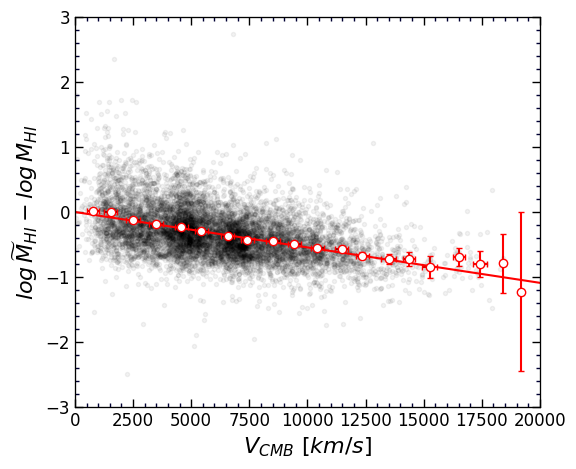

In [53]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = V3k

X = X[X0>2.2]
Y = Y[X0>2.2]
ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        
        N = len(xp)
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.mean(yp)/np.sqrt(N), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe, capsize=2) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
mc = fit[0] #; bc=fit[1]
ax.plot(x, mc*x, '-', color='r')
print(mc, np.sqrt(cov))

# ff, cov = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2, cov=True)
# x = np.linspace(0,5000,1000)
# y = x*0.
# n = len(ff)
# for i in range(n):
#     y += ff[i]*x**(n-i-1)

    
# ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log \/\widetilde{M}_{HI}  - log\/ M_{HI}$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

# ax.ticklabel_format(useMathText=True)

In [54]:
def HI_corrector(mc, bc, V3k):
    
    return mc*V3k+bc

In [55]:
PGC_outlier_1 = [    356,    1286,    1553,    2080,    2266,    2768,    3084,
          3174,    3235,    3717,    3763,    5043,    6054,    6438,
          6966,    6982,    9399,   15460,   21673,   22381,   23355,
         27640,   30358,   32707,   35942,   36349,   36466,   42938,
         43726,   45887,   50012,   51450,   53728,   66948,   67511,
         69016,   83427,   84490,   90431,   90844,   91252,  142838,
        142840,  169737, 4310833, 5057394, 5057398]

PGC_outlier_2 = [   2712,    3081,    3133,    3247,    4387,    6889,    9134,
         36778,   53291,   70708,   71795,   85607,  138562,  142824,
        169989,  170138, 1056132, 1129847, 5076801]


iter:  0
iter:  1
3.321197016433276 10.32309670823956


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-80aaabac15d9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-72-80aaabac15d9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-72-80aaabac15d9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy

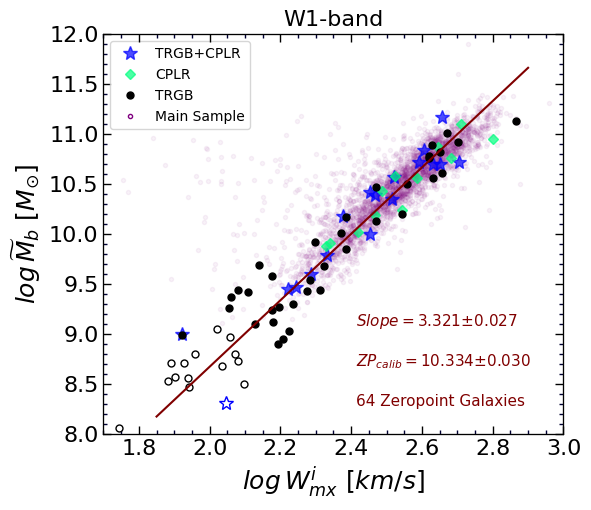

In [72]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_W1 + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), dlogMb*0.+0.01, clip=3.)
    
    dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    



fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
MM = calib.M1.values
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[MM<-16.1], X[MM<-16.1]-2.5, sigma=np.sqrt(Xe[MM<-16.1]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='purple', alpha=0.05) 


ind, = np.where((MM>-16.1)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((MM<=-16.1)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((MM>-16.1)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='springgreen', mfc='white') 
ind, = np.where((MM<=-16.1)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='springgreen', alpha=0.7, label='CPLR') 


ind, = np.where((MM>-16.1)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((MM<=-16.1)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='purple', label='Main Sample', mfc='white') 
#######################################################################


# ID = dff.index.values
# for i in range(len(ID)):
#     if ID[i] in PGC_outlier_1:
#         ax.plot([logW[i]], [logMass[i]], 'r.', alpha=0.5)
#     if ID[i] in PGC_outlier_2:
#         ax.plot([logW[i]], [logMass[i]], 'b.', alpha=0.5)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("W1-band", fontsize=16)



# X = logW
# Y = logMass
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='magenta', ms=6, mfc='white')   
        
# for i in np.arange(8,12,0.5):
#     xp = []
#     yp = []
#     for ii in range(len(Y)):
#         xi = Y[ii]
#         if xi>=i and xi<i+0.5:
#             xp.append(xi)
#             yp.append(X[ii])
#     if len(xp)>0:
#         ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
#                     color='r', ms=6)  
        
        
# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')



x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[MM<-16.1])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')


ax.legend(loc=2)

# ax.legend(bbox_to_anchor=(0.65, 0.50), loc=2)

In [21]:
# b0 = zp_calib

1535
868
9


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-b73e10d55eb1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


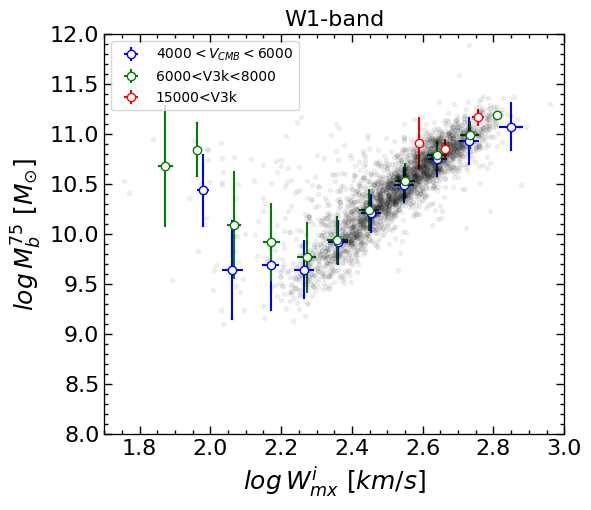

In [22]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{CMB}<6000$'
ind, = np.where((V3k>4000)&(V3k<6000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label='6000<V3k<8000'
ind, = np.where((V3k>6000)&(V3k<8000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label='15000<V3k'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("W1-band", fontsize=16)

ax.legend()

In [23]:
def getDM(mag, Wlog, F21, m0, b0, D, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [24]:
dff = df[(df.Qw>0)&(df.elgWi>0)&(df.lgWmxi>0)]
mag = dff["w1***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values

N = len(dff)
M1_fid = np.zeros(N)
pp=0

for j in range(N):
    mag_ = mag[j]

    D = np.arange(500)
    delta = D*0.
    
    for i in range(500):
        delta[i] =  D[i] - getDM(mag[j], Wlog[j], F21[j], m0, b0, D[i], V3k[j])
    


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

    try:
#         D_left = np.max(D[delta<0])
#         D_right = np.min(D[delta>0])
#         D_root = 0.5*(D_left+D_right)
        D_root = interpol(D, delta)
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid
    except:
        D_root = np.max(D[delta<0])
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid    
        print("flag (j, pgc): ", j, PGC[j])
        pp+=1
    if j%1000==0:
        print(j)
        
    if PGC[j]==1781:
        print(j, mag_, DM_fid, D_root)

print("Number of concerning distances:", pp)

<ipython-input-23-c7a95d5ae245>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
<ipython-input-23-c7a95d5ae245>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


0
180 15.65 29.53450341370224 8.070504476490342
1000
2000
3000
4000
5000
Number of concerning distances: 0


8.070504476490342


<ipython-input-23-c7a95d5ae245>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
<ipython-input-23-c7a95d5ae245>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


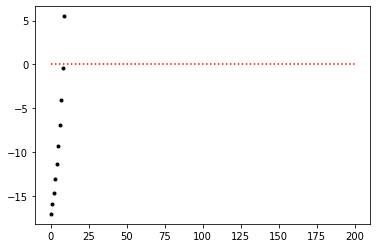

In [25]:
j = 180
D = np.arange(500)
delta = D*0.
for i in range(500):
        delta[i] =  D[i] - getDM(mag[j], Wlog[j], F21[j], m0, b0, D[i], V3k[j])

plt.plot(D, delta, 'k.') 
plt.plot([0,200], [0,0], "r:")

print(interpol(D, delta))


<ipython-input-26-523c8db1809b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = M1_fid - dff.M1_75.values


Text(0.5, 1.0, 'BTFR: W1-band')

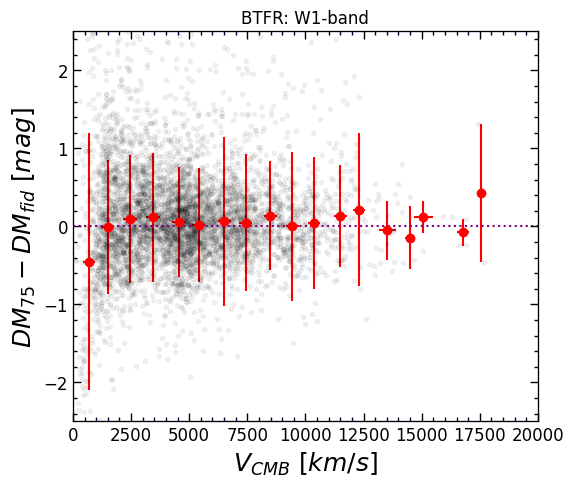

In [26]:
dff['dDM'] = M1_fid - dff.M1_75.values

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)


ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("BTFR: W1-band")


Text(0.5, 1.0, 'BTFR: W1-band')

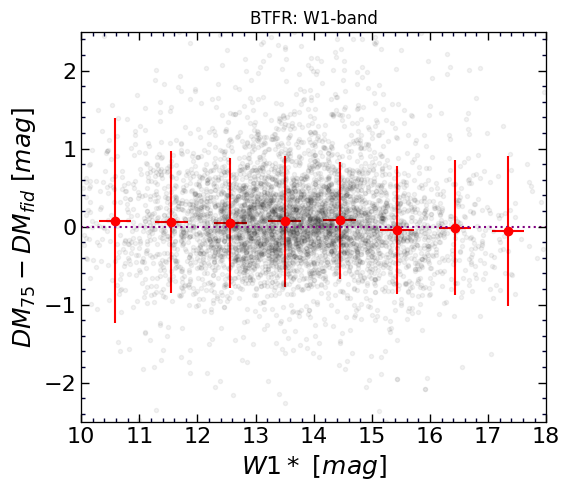

In [27]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['w1***'].values
Y = dff.dDM.values
V = dff.V3k.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("BTFR: W1-band")

In [28]:
dff['DM1_fid'] = dff["w1***"] - M1_fid

dff[['V3k', 'Vmod', 'DM_75', 'DM1_fid', 'F21', 'eF21', 'lgWmxi', 'elgWi', 'Qw', 'w1***', 'logMs_W1']].to_csv("BTFR_W1_distances.csv")

<ipython-input-28-2b29125361d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DM1_fid'] = dff["w1***"] - M1_fid
